<a href="https://colab.research.google.com/github/kezif/logotypes_recog/blob/main/Logos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Logo recognition in invoices
Today we would try t find logos in arbitatary invoice. It could be usefull if you company working with large number of clients with different type of invoices.
I Have a little collection of some documents, let's have a look at it.

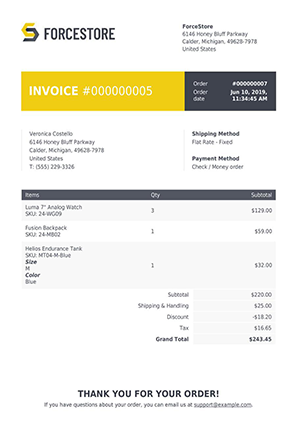


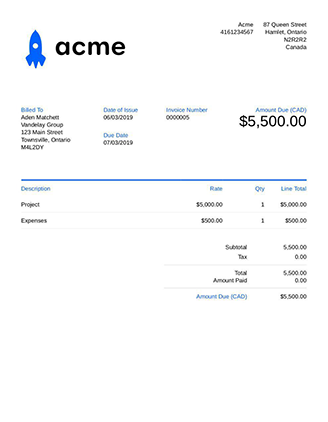

All images could be found [here](https://github.com/kezif/logotypes_recog/blob/main/source.7z)

It seems like most of the logotypes are situated on the top corner of the document and have padding around it. So i want to utilize it.
Also my examples are all digital documents so i dont need to align them.

The idea of the algorithm is simple:

1.  Find non empty areas of the document
2.  Filter everything that is not  a logo

Let's try it.


## Loading data



In [ ]:
!wget https://github.com/kezif/logotypes_recog/blob/main/firstbatch.7z
!7z x firstbatch.7z -odata
!ls /content/data

--2023-01-05 18:08:35--  https://github.com/kezif/logotypes_recog/blob/main/firstbatch.7z
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘firstbatch.7z.2’

firstbatch.7z.2         [ <=>                ] 134.54K  --.-KB/s    in 0.01s   

2023-01-05 18:08:35 (10.5 MB/s) - ‘firstbatch.7z.2’ saved [137769]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs AMD EPYC 7B12 (830F10),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 377461 bytes (369 KiB)

Extracting archive: firstbatch.7z
--
Path = firstbatch.7z
Type = 7z
Physical Size = 377461
Headers Size = 245
Method = LZMA2:768k
Solid = +
Blocks = 1

  0%    
Would you like to replace the existing file:
  Path:     data/1.jpg
  Size:     

# Finding regions
To find regions of interest i would use simple cv2 algorithm that utilizes eroding and dilation to clean and chunk up data and then find bounding box around it.

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob

To make image more managable to debug and standartize it size - I played around with resizing and after experimentation picked best variant.

In [ ]:
img = cv2.imread(r'/content/4.jpg')
CONV_SHAPE = (1100, 900)
img = cv2.resize(img, CONV_SHAPE, interpolation = cv2.INTER_AREA)

Also because logotypes are at the top of document, we dont really need bottom part

In [ ]:
img = img[:200]

Using erode and dilate operation we can transform text into one big chunk. After that we could find where it located in the image.

I tried different setting of those operations and found that skewed  kernel work best because it can join logotype with company name (as with *acme* invoice). 
And 5/3 is best combo for dilating/eroding to get optimal chunks of data.
(my dilate and erode operations are interted, prob because i need negative mask)

In [ ]:
thresh = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
kernel = np.ones((3, 12), np.uint8)   
thresh = cv2.erode(thresh, kernel, iterations=5)
thresh = cv2.dilate(thresh, kernel, iterations=3)
ret, thresh =  cv2.threshold(thresh,220,255,cv2.THRESH_BINARY)

Simple function to visualise

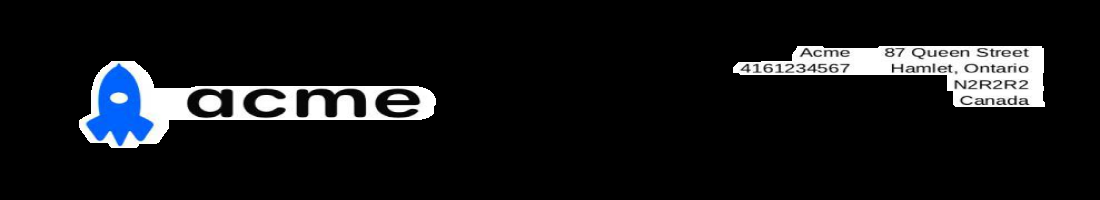

In [ ]:
cv2_imshow(cv2.bitwise_and(img,img, mask=(255-thresh)))

Now let's do it for all samples:

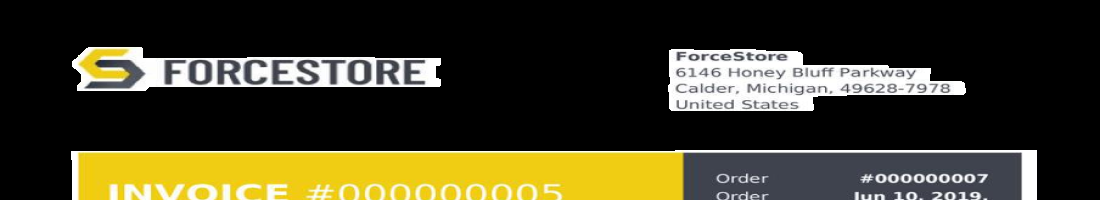

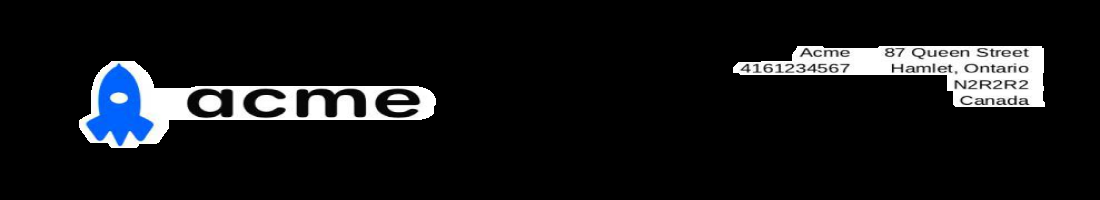

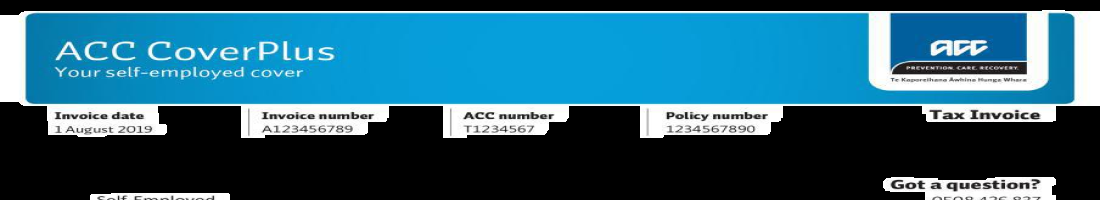

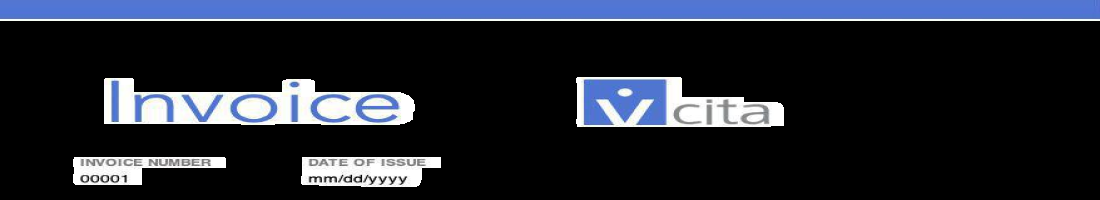

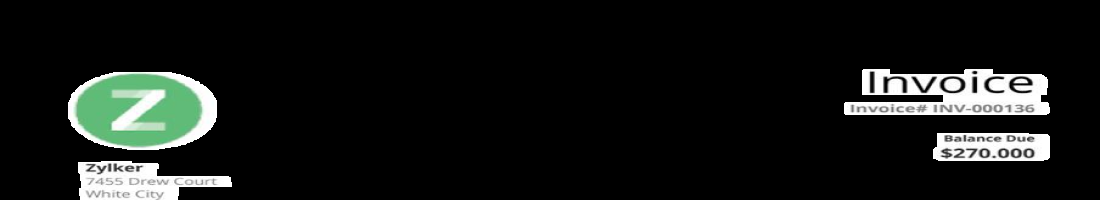

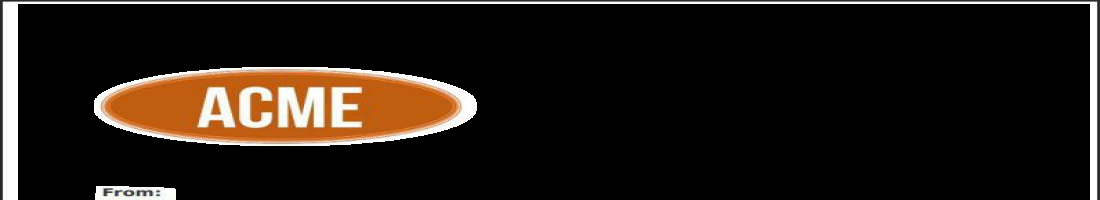

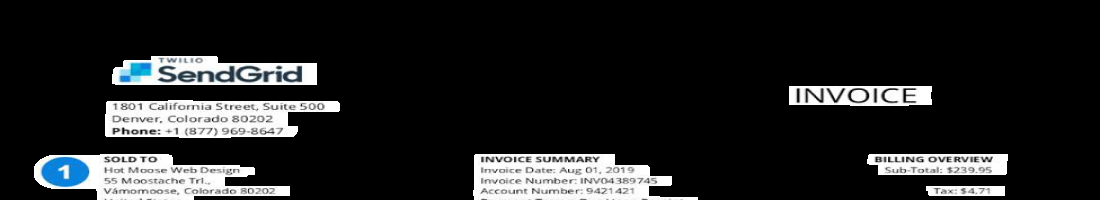

In [ ]:
def get_tresh(path, test=False):
    img = cv2.imread(path)
    img = cv2.resize(img, CONV_SHAPE, interpolation = cv2.INTER_AREA)
    img = img[:200]

    thresh = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    
    #ret, img =  cv2.threshold(img,220,255,cv2.ADAPTIVE_THRESH_MEAN_C)  # images are digital so adaptive threshold would not benefit here
    kernel = np.ones((3, 12), np.uint8)   
    thresh = cv2.erode(thresh, kernel, iterations=5)
    thresh = cv2.dilate(thresh, kernel, iterations=3)
    ret, thresh =  cv2.threshold(thresh,220,255,cv2.THRESH_BINARY)
    if test:
        cv2_imshow(cv2.bitwise_and(img,img, mask=(255-thresh)))
    return img, thresh


for _path in os.listdir('/content/data'):
    #if _path.endswith('.jpg') or  _path.endswith('.png'):
    get_tresh(os.path.join('/content/data', _path), test=True)



It seems like my parameters work fine on the most cases but fails if logo on the colorfull background. In my initial analysis i didnt account this case. I want to keep algorithm simple so just ignore this case. 


Now with thresholds we can find bounding boxes:

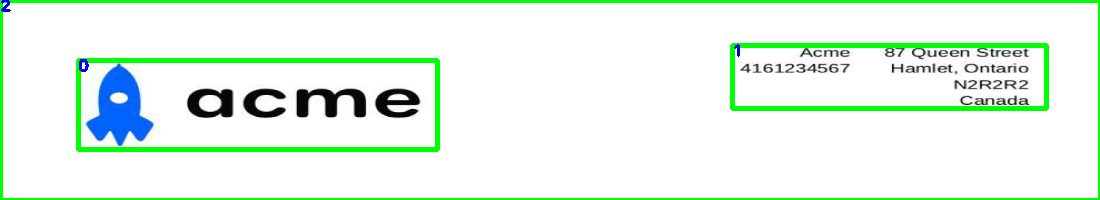

In [ ]:
contours, hier = cv2.findContours(thresh, cv2.RETR_LIST , cv2.CHAIN_APPROX_SIMPLE  )

i = img.copy()
rects = []
for n, count in enumerate(contours):
    a,b,h,w = cv2.boundingRect(count)
    rects.append((a,b,h,w))
    cv2.rectangle(i, (a,b), (a+h,b+w), (0,255,0), 4)
    cv2.putText(i,str(n), (a,b+10),cv2.FONT_HERSHEY_SIMPLEX,0.5, (255,0,0),2)
cv2_imshow(i)

That is all that i want to do in part one of my algorithm. Now we can do part two
# Filtering regions

I have pretty simple idea about how I'm gonna do it. 
At first i want to exlude result where bounding box is as big as image. Which is strigforward.

Next idea is to use ocr to find boxes with text and filter out ones with forbidden words such as `invoice`, `city`, `date`, that indicate that regions in it have other non logo information.

At last filter solid blanks of color.

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract
from string import punctuation

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Pytesseract is rich ocr library that is capable of easy to the end user conversion of image to text data. For your project basic `image_to_string` method would be enough.

For example:

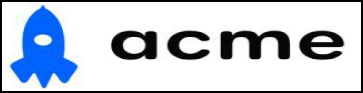

& acme



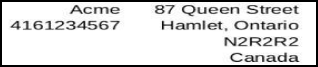

Acme 87 Queen Street
4161234567 Hamlet, Ontario
N2R2R2
Canada:



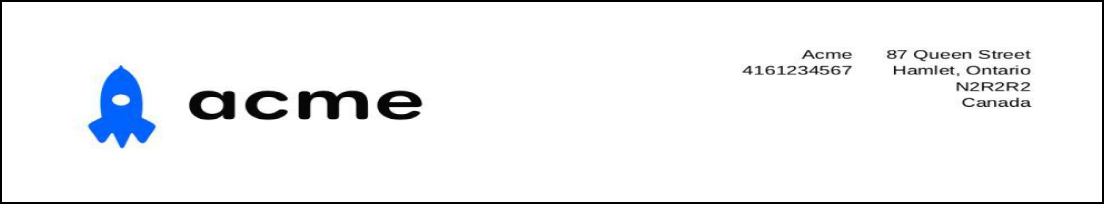

Acme —_87 Queen Street
4161234567 Hamlet, Ontario
N2R2R2

& acme ent



In [ ]:
def padding(i):
    # return image with frame around it. Fow visualisation
    return np.pad(i.copy(), ((2,2),(2,2), (0,0)),'constant')

BAD_WORDS = {'invoice', 'city', 'date'}
for x,y,h,w in rects:
    roi = img[y:y+w, x:x+h]
    rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    text = pytesseract.image_to_string(rgb)
    if not any(w.lower() in BAD_WORDS for w in text.split()):
        cv2_imshow(padding(roi))
        print(text)

Method of filtering using dictionary is simple and can't cover all cases. I tried to build dictionary that would cover most of the cases at least from my exapmples.

In [ ]:
BAD_WORDS = {'invoice', 'city', 'date', 'street', 'states','billing', 'phone', 'due', 'tax'}

To filter huge bounding boxes I'll use this expression *`9`*   `h >= CONV_SHAPE[0] * 0.9`. Where width of box compaped to CONV_SHAPE (desired shape of resized image from begining).

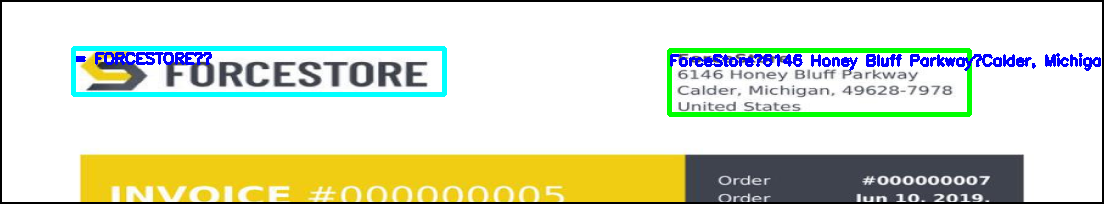

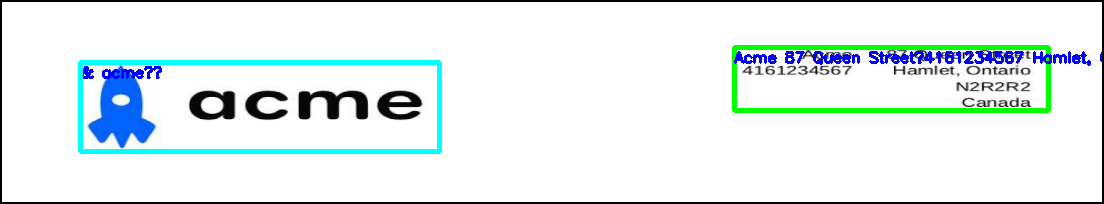

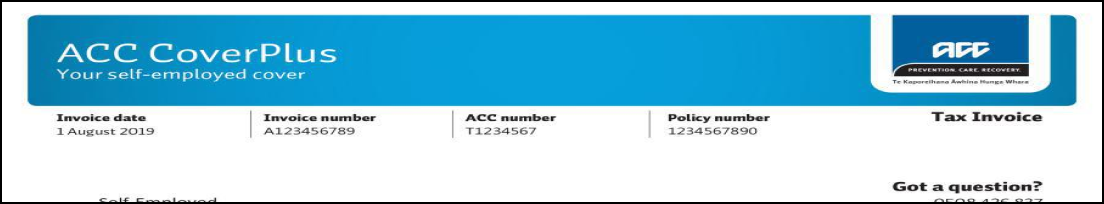

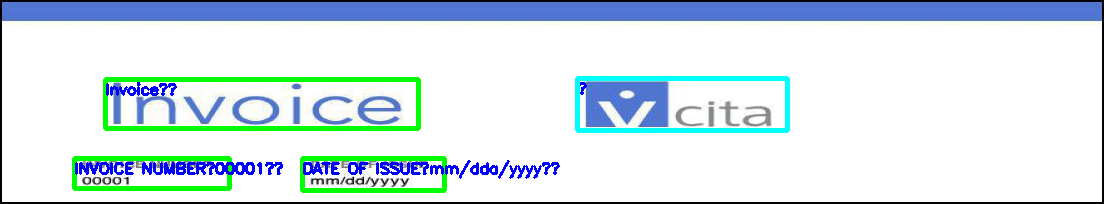

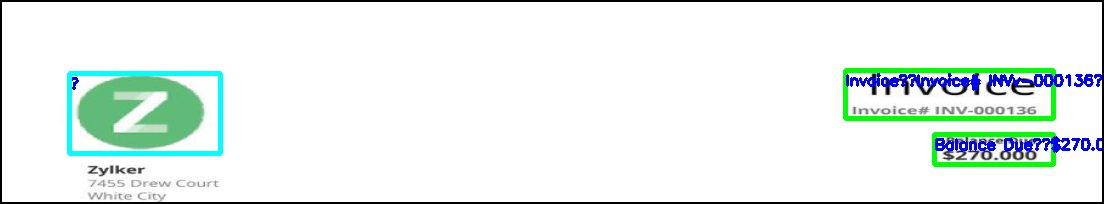

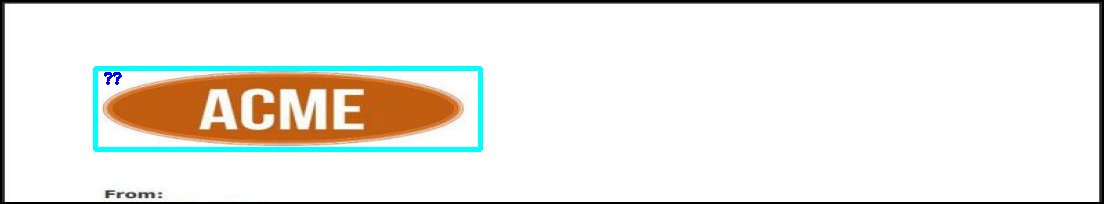

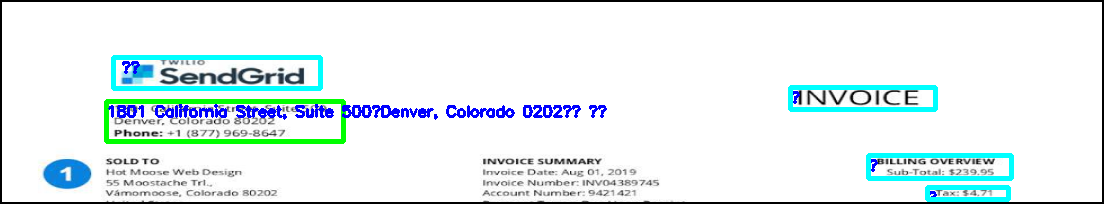

In [ ]:
def find_logos(path, debug=False):
    img, tresh = get_tresh(path)
    contours, hier = cv2.findContours(tresh, cv2.RETR_LIST , cv2.CHAIN_APPROX_SIMPLE  )

    i = img.copy()  # image with visualisation
    logos = []
    for count in contours:
        x,y,h,w = cv2.boundingRect(count)
        if h >= CONV_SHAPE[0] * 0.9:  # reject boxes that are too wide (whole document)
            continue
    
        roi = img[y:y+w, x:x+h]  # get region of image from bounding box
        rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        text = pytesseract.image_to_string(rgb)  # convert to text

        if debug:
            cv2.rectangle(i, (x,y), (x+h,y+w), (0,255,0), 4)
            cv2.putText(i,text, (x,y+15),cv2.FONT_HERSHEY_SIMPLEX,0.5, (255,0,0),2)

        text = text.translate(str.maketrans('', '', punctuation))  # remove punctuation
        if  any(w.lower() in BAD_WORDS for w in text.split()):  # if any of the excracted word is in dictionary then discard the box
            continue

        logos.append((x,y,h,w))
        if debug == True:
            cv2.rectangle(i, (x,y), (x+h,y+w), (255,255,0), 3)

    if debug:
        cv2_imshow(padding(i))
    return logos
    

for _path in os.listdir('/content/data'):
    find_logos(os.path.join('/content/data', _path), debug=True)

This method work in most cases but sometimes fails and return more than one result. That is not a problem because we can use a little hack about cv2 threshold method. That is that thresholds are returned from bottom right to the top left. Thats ideal behaviour for us because logos are most likely located in the top left of image. Because of that logo will almost always will be the last member of returned collection. 

So for examaple in *SendGrid* case:

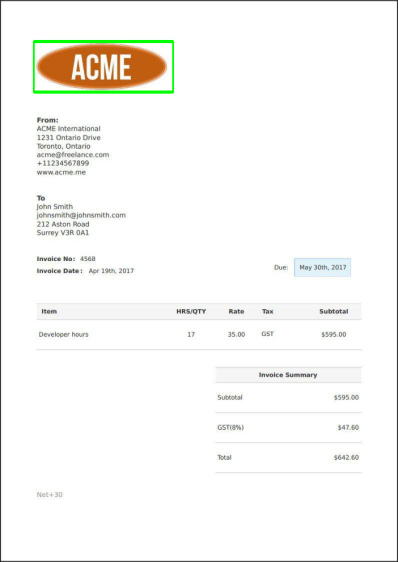

In [ ]:
path = '/content/data/3.jpg'
boxes = find_logos(path, debug=False)

img__ = cv2.imread(path)
orig_shape = img__.shape
img__ = cv2.resize(img__, CONV_SHAPE, interpolation = cv2.INTER_AREA)

(x,y,h,w) = boxes[-1]
cv2.rectangle(img__, (x,y), (x+h,y+w), (0,255,0), 4)
img__ = cv2.resize(img__, (orig_shape[1]//2,orig_shape[0]//2), interpolation = cv2.INTER_AREA)
cv2_imshow(img__)

In previous cell I layed down basis for the end path-toLogo function. Let's write it and test on more images!

In [ ]:
def path2logo(path, scale_down:int=None, show_im=False):
    boxes = find_logos(path)
    
    if len(boxes) == 0:
        print(f'{path=} didn\'t found boxes')
        return ()
    
    img_og = cv2.imread(path)  #  I don't feel like rewriting previous functions so would read second time..
    
    orig_shape = img_og.shape[0], img_og.shape[1]
    scale = (orig_shape[1] / CONV_SHAPE[0], orig_shape[0] / CONV_SHAPE[1])  #  it was very long session of coding i dont understand why we need to divide x by y and vise versa. It work tho

    (x,y,h,w) = boxes[-1]
    x = int(x*scale[0])
    h = int(h*scale[0])
    y = int(y*scale[1])
    w = int(w*scale[1]) 

    cv2.rectangle(img_og, (x,y), (x+h,y+w), (0,255,0), 4)

    if scale_down is not None:
        img_og = cv2.resize(img_og, (orig_shape[1]//scale_down,orig_shape[0]//scale_down), interpolation = cv2.INTER_AREA)

    if show_im:
        cv2_imshow(img_og)
    return (x,y,h,w)

In [ ]:
!wget https://github.com/kezif/logotypes_recog/blob/main/many.zip
!unzip many.zip -d many

--2023-01-05 19:07:30--  https://github.com/kezif/logotypes_recog/blob/main/many.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘many.zip.2’

many.zip.2              [ <=>                ] 134.28K  --.-KB/s    in 0.01s   

2023-01-05 19:07:30 (9.11 MB/s) - ‘many.zip.2’ saved [137504]

Archive:  many.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of many.zip or
        many.zip.zip, and cannot find many.zip.ZIP, period.


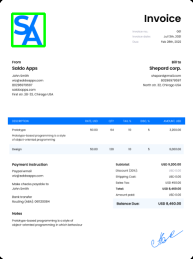

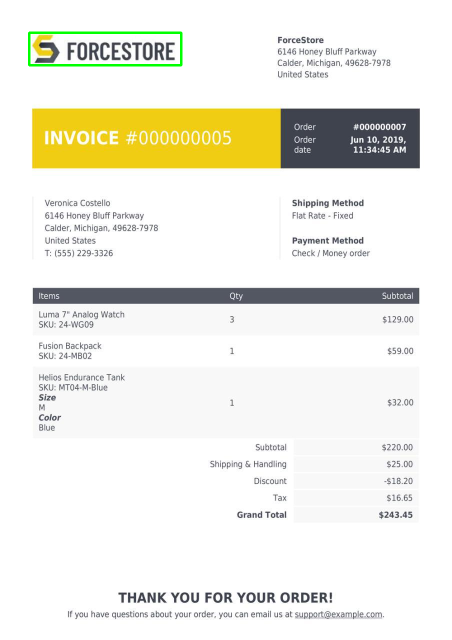

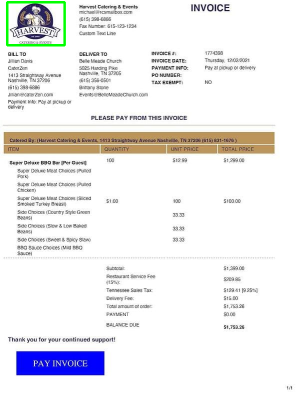

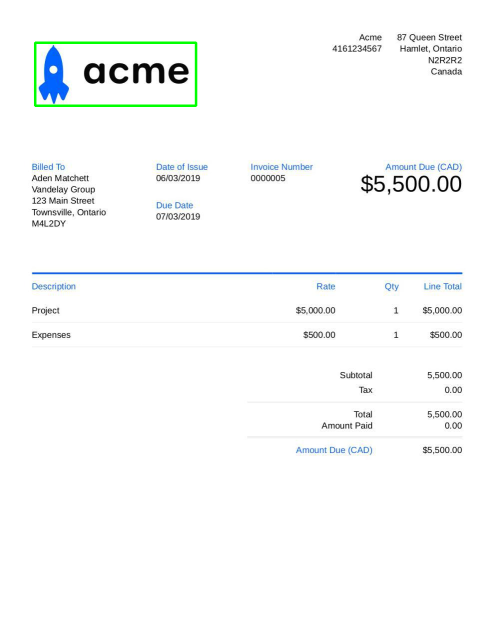

path='/content/many/2.jpg' didn't found boxes


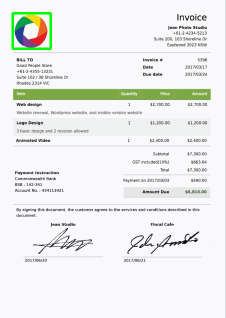

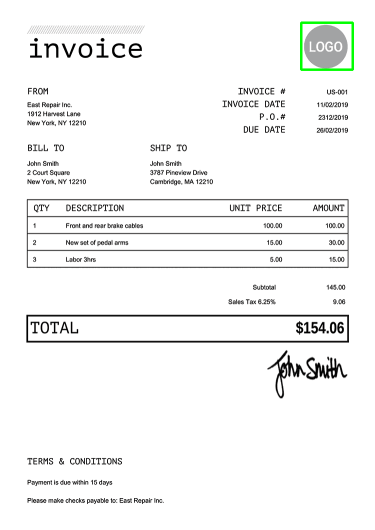

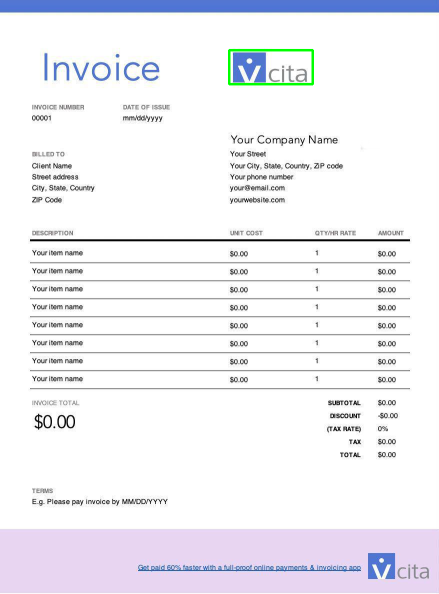

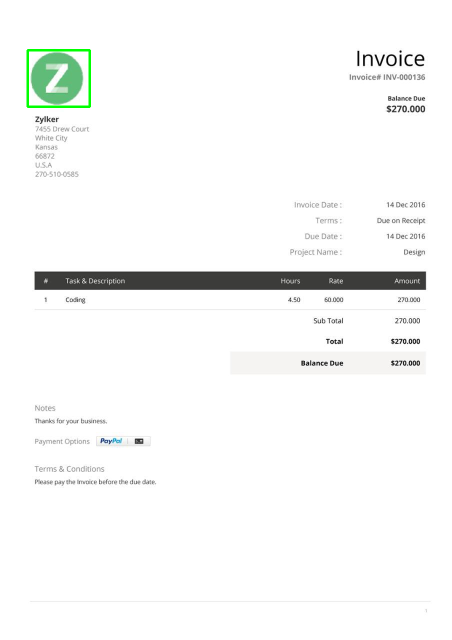

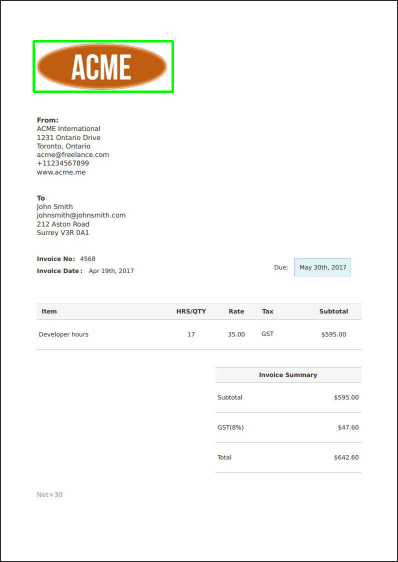

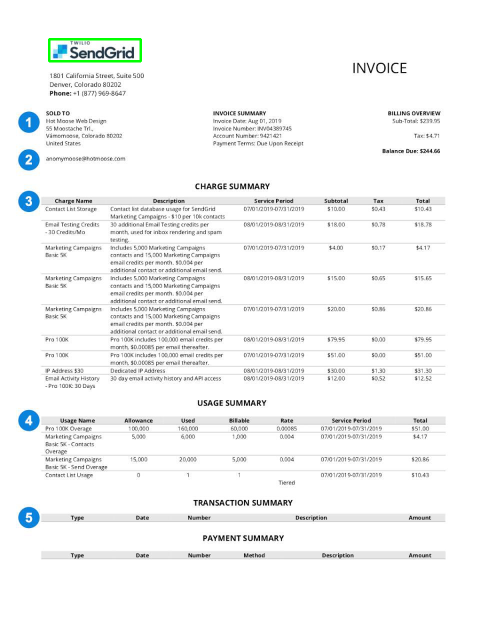

path='/content/many/10.png' didn't found boxes


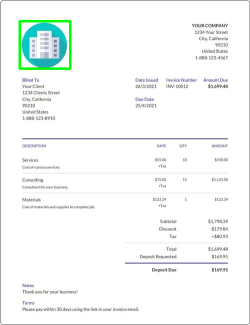

In [ ]:
for _path in os.listdir('/content/many'):
    path2logo(os.path.join('/content/many', _path),2 , show_im=True)

Let's look at the images where algorithm didn't found logo

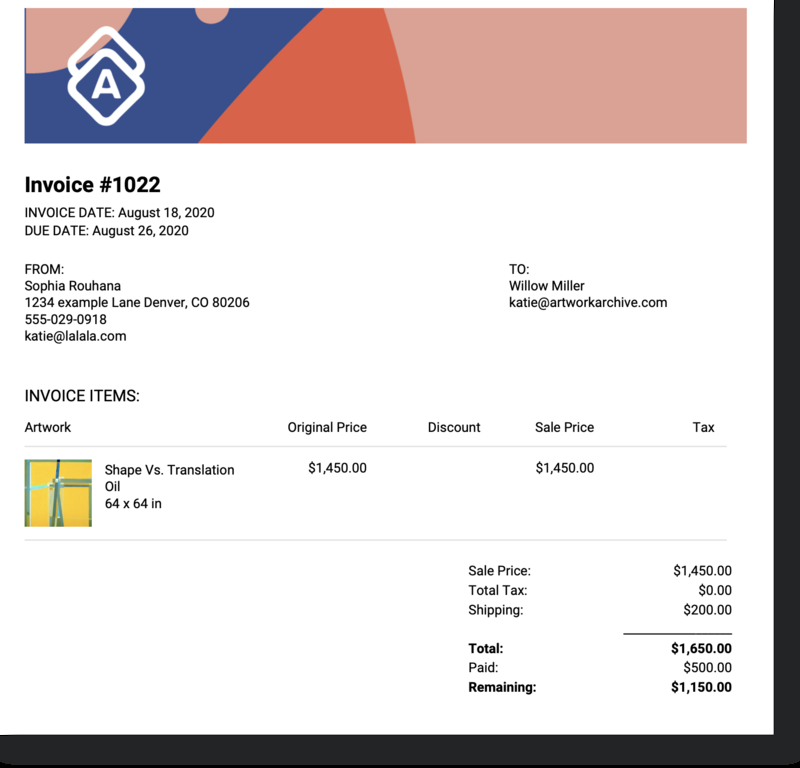

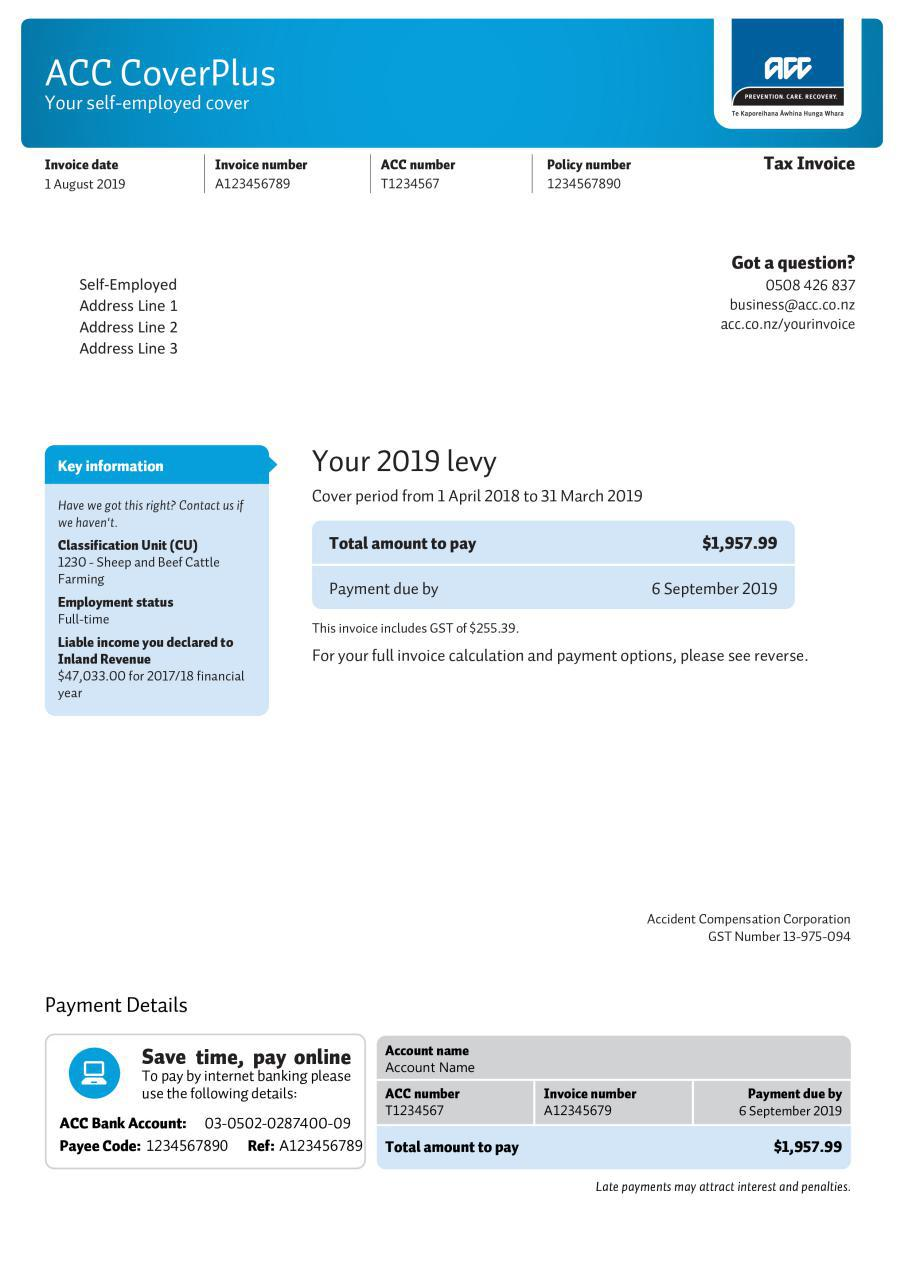

In [ ]:
cv2_imshow(cv2.imread(r'/content/many/10.png'))
cv2_imshow(cv2.imread(r'/content/many/2.jpg'))


Here we can verify that algorithm didn't working when background is colored. Otherwise it looks like it work as expected. Of course it could break on other  examples, if you intersted in it - give it a go. It would be interesting. 

Also I'm pretty sure that this problem could be solved using convolutional neural networks. But I don't where to start. If you have any ideas - please contect me.
Have a nice day ><